In [22]:
%load_ext autoreload
%autoreload 1
%aimport ecg_get_data
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ECGplot
import Models 
from train_test_validat import *
from self_attention import *
import  ecg_get_data 
import matplotlib.pyplot as plt
import ecg_plot

import torch
import torch.utils.data as Data
import random

import time
import os
import gc

random_seed = 2
torch.manual_seed(random_seed)    # reproducible
torch.cuda.manual_seed_all(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime()) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_path =  './npy_ECG/' #路径
lable_path = './label.npy'
model_path = './model/'+time_str
log_path = './log/'+  time_str


EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
test_Dataset = ecg_get_data.ECG_Dataset("./data/test/",EcgChannles_num,EcgLength_num)

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35768 (\N{CJK UNIFIED IDEOGRAPH-8BB8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20964 (\N{CJK UNIFIED IDEOGRAPH-51E4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


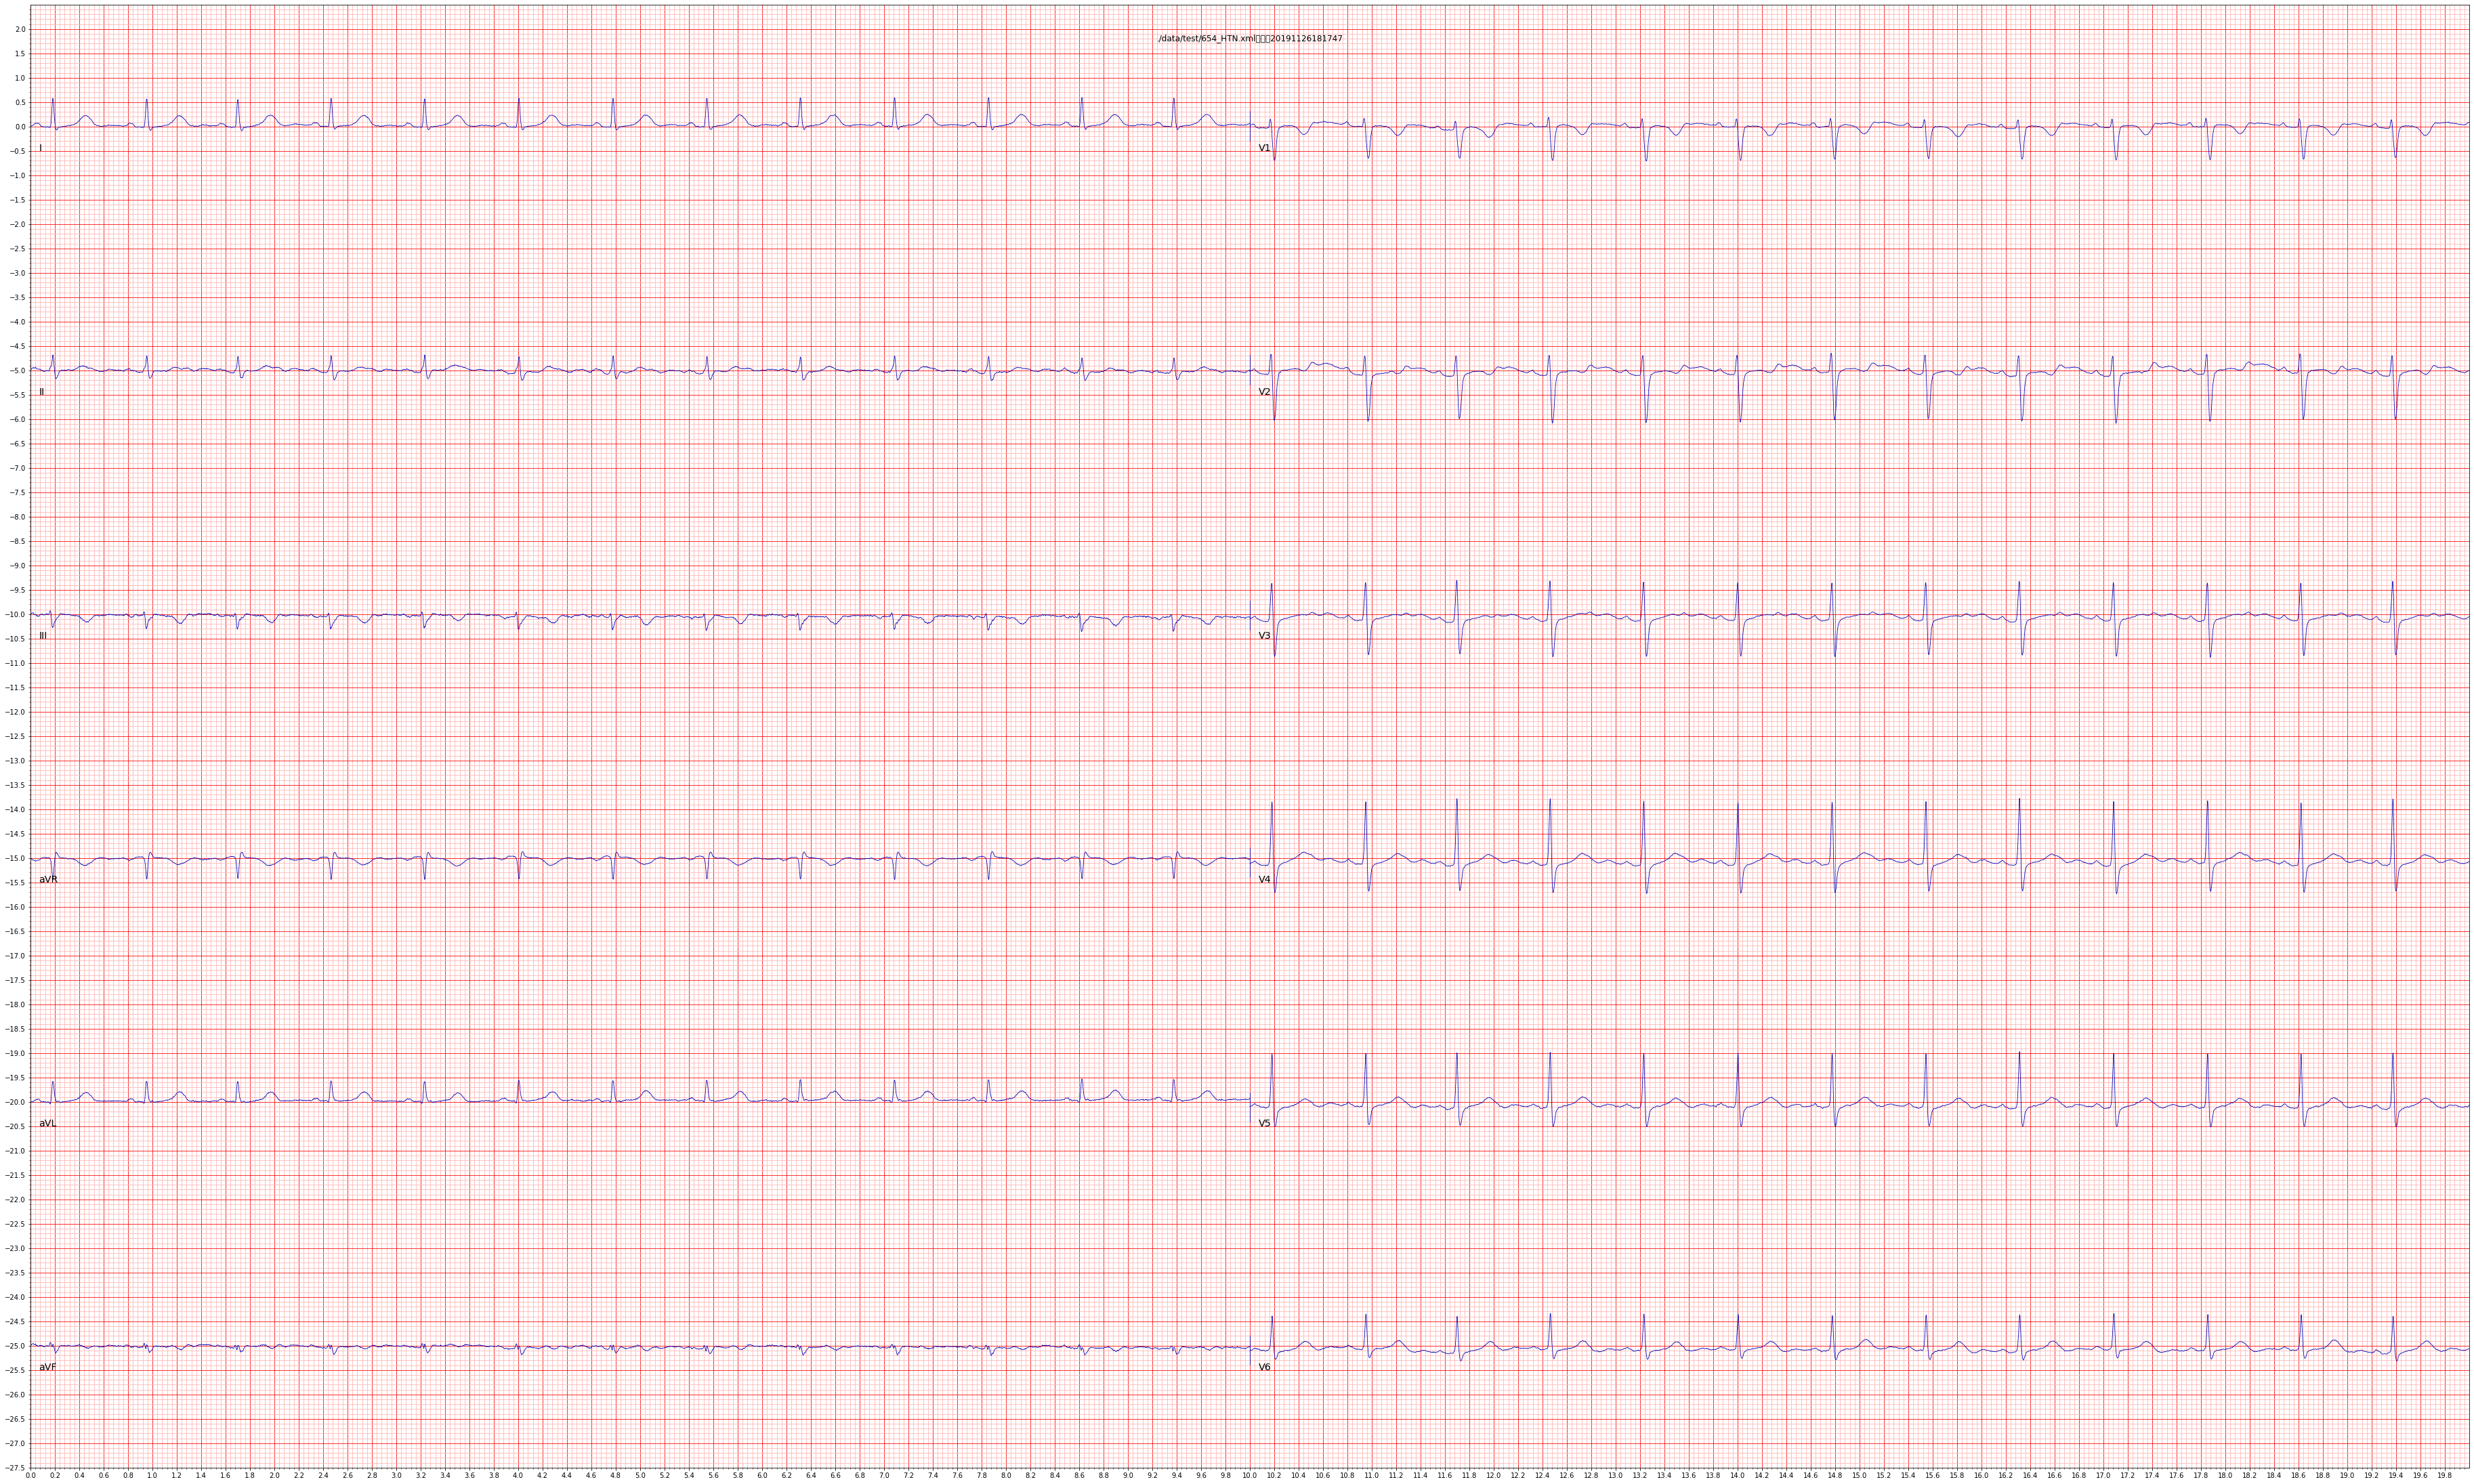

In [4]:
ECG,label = test_Dataset.__getitem__(55)
inf,path = test_Dataset.get_basic_inf(55)
ecg_plot.plot(ECG/1000, sample_rate = 500, title = path + inf[0]+inf[1],row_height= 10,show_grid=True,show_separate_line=True)
#ecg_plot.save_as_png(inf[1],'/workspace/data/OneDrive - mail.hfut.edu.cn/ECG/Interpretable_HTN//PNG_ECG/',dpi = 100)

In [12]:
sss = np.zeros((3,3,3))
(sss[:,1:2,:]).shape

(3, 1, 3)

## -----Old-----

In [3]:
x = ecg_get_data.load_data(data_path,EcgChannles_num=EcgChannles_num,EcgLength_num=EcgLength_num)
y = ecg_get_data.load_label(lable_path)

100%|██████████| 1698/1698 [00:10<00:00, 159.22it/s]


In [4]:
x = ecg_get_data.amplitude_limiting(x,2500)

In [5]:
x.max()

2500.0

In [6]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x,y,train_size=0.8,random_state = random_seed,shuffle = True,stratify=y)
gc.collect()
print("         HTN     NHTN ")
print("train: %5d   %5d" % (train_y.sum(),len(train_y)-train_y.sum()))
print("test : %5d   %5d" % (test_y.sum(),len(test_y)-test_y.sum()))

         HTN     NHTN 
train:   558     800
test :   140     200


In [8]:
train_x ,train_y = ecg_get_data.sliding_window(train_x ,train_y,2000,5)
test_x ,test_y = ecg_get_data.sliding_window(test_x ,test_y,2000,5)
print("         HTN     NHTN ")
print("train: %5d   %5d" % (train_y.sum(),len(train_y)-train_y.sum()))
print("test : %5d   %5d" % (test_y.sum(),len(test_y)-test_y.sum()))

400


100%|██████████| 1358/1358 [00:00<00:00, 1449.65it/s]


10864 10864
400


100%|██████████| 340/340 [00:00<00:00, 2836.06it/s]

2720 2720
         HTN     NHTN 
train:  4464    6400
test :  1120    1600


In [29]:
BATCH_SIZE = 16
FOLDS = 1
EPOCHS = 5000  
PATIENCE = 64
LR = 0.01

In [30]:
from torch.utils.tensorboard import SummaryWriter   
os.makedirs(model_path, exist_ok=True)
writer = SummaryWriter(log_path)
from torchsummary import summary

In [31]:
torch.cuda.empty_cache()# 清空显卡cuda
#NET = [Models.resnet18(input_channels=12, inplanes=32, num_classes=2) for i in range(FOLDS)]
NET = [Models.channels_split_CNN() for i in range(FOLDS)]
print(summary(NET[0], (EcgChannles_num,5000), device="cpu"))
writer.add_graph(NET[0],torch.rand([1,EcgChannles_num,EcgLength_num]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 5000]             176
       BatchNorm1d-2             [-1, 16, 5000]              32
              ReLU-3             [-1, 16, 5000]               0
         MaxPool1d-4             [-1, 16, 2500]               0
            Conv1d-5             [-1, 32, 2500]           2,560
       BatchNorm1d-6             [-1, 32, 2500]              64
              ReLU-7             [-1, 32, 2500]               0
         MaxPool1d-8             [-1, 32, 1250]               0
            Conv1d-9             [-1, 16, 5000]             176
      BatchNorm1d-10             [-1, 16, 5000]              32
             ReLU-11             [-1, 16, 5000]               0
        MaxPool1d-12             [-1, 16, 2500]               0
           Conv1d-13             [-1, 32, 2500]           2,560
      BatchNorm1d-14             [-1, 3

/workspace/data/OneDrive - mail.hfut.edu.cn/ECG/Interpretable_HTN/self_attention.py:131: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if dim % 2 != 0:
/workspace/data/OneDrive - mail.hfut.edu.cn/ECG/Interpretable_HTN/self_attention.py:135: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  i_matrix = torch.arange(dim//2, dtype=torch.float)
/workspace/data/OneDrive - mail.hfut.edu.cn/ECG/Interpretable_HTN/self_attention.py:150: TracerWarning: Conve

In [32]:
from torch.optim.lr_scheduler import CosineAnnealingLR

for fold in range(FOLDS):
    
    early_stopping = EarlyStopping(PATIENCE, verbose=True, model_path=model_path, delta=0)
    #train_dataset,valid_dataset = get_k_fold_dataset(fold=int(fold+1),x = train_x,y=train_y,k=FOLDS,random_seed = random_seed)
    valid_dataset  = ecg_get_data.load_numpy_dataset_to_tensor_dataset(test_x,test_y)
    train_dataset =  ecg_get_data.load_numpy_dataset_to_tensor_dataset(train_x,train_y)
    train_dataloader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = Data.DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

    NET[fold].to(DEVICE)
    optimizer  = torch.optim.SGD(NET[fold].parameters(), lr=LR,weight_decay=1e-1)  
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()   
    #等间隔调整学习率
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = 32)
    best_loss = 3
    for epoch in range(1,EPOCHS):
        time_all=0
        start_time = time.time()
        train_loss,train_acc = train_model(train_dataloader, NET[fold], criterion, optimizer,DEVICE) # 训练模型
        scheduler.step() # 学习率迭代

        time_all = time.time()-start_time
        validate_loss,validate_acc = test_model(valid_dataloader,criterion,NET[fold],DEVICE) # 测试模型
        writer.add_scalars(main_tag=str(fold)+'_Loss',tag_scalar_dict={'train': train_loss,'validate': validate_loss},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_Accuracy',tag_scalar_dict={'train': train_acc,'validate': validate_acc},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_LearningRate',tag_scalar_dict={'LR': optimizer.state_dict()['param_groups'][0]['lr']},global_step=epoch)

        print('- Epoch: %d - Train_loss: %.5f - Train_acc: %.5f - Val_loss: %.5f - Val_acc: %5f - T_Time: %.3f' %(epoch,train_loss,train_acc,validate_loss,validate_acc,time_all))
        print('当前学习率：%f' %optimizer.state_dict()['param_groups'][0]['lr'])

        if validate_loss < best_loss:
            best_loss = validate_loss
            print('Find better model in Epoch {0}, saving model.'.format(epoch))
            #torch.save(NET[fold],  model_path+'/best_model_' + str(fold) + '.pt')  # 保存最优模型
        #else:
            #scheduler.step() # 学习率迭代
        #是否满足早停法条件
        if(early_stopping(validate_loss,NET[fold])):
            print("Early stopping")
            break

    print('Fold %d Training Finished' %(fold+1))
    torch.cuda.empty_cache()# 清空显卡cuda
print('Training Finished')

- Epoch: 1 - Train_loss: 0.67078 - Train_acc: 0.58277 - Val_loss: 0.66516 - Val_acc: 0.568182 - T_Time: 4.312
当前学习率：0.009976
Find better model in Epoch 1, saving model.
Validation loss decreased (inf --> 0.665164).  Saving model ...
                    --------------------------------------------------

- Epoch: 2 - Train_loss: 0.64623 - Train_acc: 0.62689 - Val_loss: 0.64439 - Val_acc: 0.593750 - T_Time: 4.095
当前学习率：0.009904
Find better model in Epoch 2, saving model.
Validation loss decreased (0.665164 --> 0.644391).  Saving model ...
                    --------------------------------------------------

- Epoch: 3 - Train_loss: 0.62286 - Train_acc: 0.68508 - Val_loss: 0.62926 - Val_acc: 0.701705 - T_Time: 4.312
当前学习率：0.009785
Find better model in Epoch 3, saving model.
Validation loss decreased (0.644391 --> 0.629261).  Saving model ...
                    --------------------------------------------------

- Epoch: 4 - Train_loss: 0.60375 - Train_acc: 0.72174 - Val_loss: 0.62295 -

# ------Display the attention value-----

# -----For Leads -----

In [ ]:
test_model_path = "./model/20220907_091538/best_model_0.pt"
test_model = torch.load(test_model_path).to(DEVICE)
test_x = x[0:1698]
test_y = x[0:1698]
test_x = MAX_MIN_normalization_by_feactures(test_x)
test_x = torch.FloatTensor(test_x)  #turn numpy to tensor
test_y = torch.LongTensor(test_y)
test_dataset = Data.TensorDataset(test_x, test_y)
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
test_model.eval()

test_model.eval()
attention_value_timestep = np.zeros(EcgChannles_num,)
for i,data in enumerate(test_dataloader,0):
    inputs,labels = data[0].to(DEVICE),data[1].to(DEVICE)
    outputs = test_model(inputs)
    #print(outputs)
    _,pred = outputs.max(1) # 求概率最大值对应的标签
    #print("the label :{labels},pred is {pred}".format(labels=labels[0],pred=pred[0]))
    attention_value = test_model.attention_value
    attention_value_timestep += (((attention_value.to('cpu'))[0]).detach().numpy()).sum(axis=0)
plt.figure(figsize=(5,5))
plt.stem(np.arange(0,len(attention_value_timestep)), attention_value_timestep)
plt.xticks(np.arange(0,len(attention_value_timestep)),['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
plt.ylabel("Sum of attention value")
plt.show()

In [ ]:
print(summary(Models.CNN_ATT7(), (EcgChannles_num,EcgLength_num), device="cpu"))

In [58]:
tsss

tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.]],

        [[ 9., 10., 11., 12.],
         [13., 14., 15., 16.]],

        [[17., 18., 19., 20.],
         [21., 22., 23., 24.]]])

In [83]:
tsss = (torch.arange(1,25,1).view(3,2,4)).float()
tsss.mean(dim=2)

tensor([[ 2.5000,  6.5000],
        [10.5000, 14.5000],
        [18.5000, 22.5000]])